In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-02 02:58:51.908237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 02:58:51.912531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 02:58:51.912969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-02 02:58:52.194579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 02:58:52.195368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 02:58:52.195717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 02:58:52.196024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[8.93110216e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.89611423e+00, 5.18713713e+00],
         ...,
         [0.00000000e+00, 6.96255982e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 3.16319847e+00, 2.54732430e-01]],

        [[6.89742446e-01, 1.11229467e+00, 0.00000000e+00],
         [4.33711886e-01, 0.00000000e+00, 0.00000000e+00],
         [4.11558837e-01, 1.39536452e+00, 2.96074152e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [2.04446626e+00, 0.00000000e+00, 0.00000000e+00],
         [1.65381348e+00, 1.38834655e+00, 3.09188914e+00]],

        [[1.34770000e+00, 7.37250209e-01, 0.00000000e+00],
         [3.85406685e+00, 0.00000000e+00, 2.00655270e+00],
         [8.31186652e-01, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1

In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[8.93110216e-01, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 1.89611423e+00, 5.18713713e+00],
          ...,
          [0.00000000e+00, 6.96255982e-01, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 3.16319847e+00, 2.54732430e-01]],
 
         [[6.89742446e-01, 1.11229467e+00, 0.00000000e+00],
          [4.33711886e-01, 0.00000000e+00, 0.00000000e+00],
          [4.11558837e-01, 1.39536452e+00, 2.96074152e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [2.04446626e+00, 0.00000000e+00, 0.00000000e+00],
          [1.65381348e+00, 1.38834655e+00, 3.09188914e+00]],
 
         [[1.34770000e+00, 7.37250209e-01, 0.00000000e+00],
          [3.85406685e+00, 0.00000000e+00, 2.00655270e+00],
          [8.31186652e-01, 0.00000000e+00, 0.00000000e+0

<IPython.core.display.Javascript object>


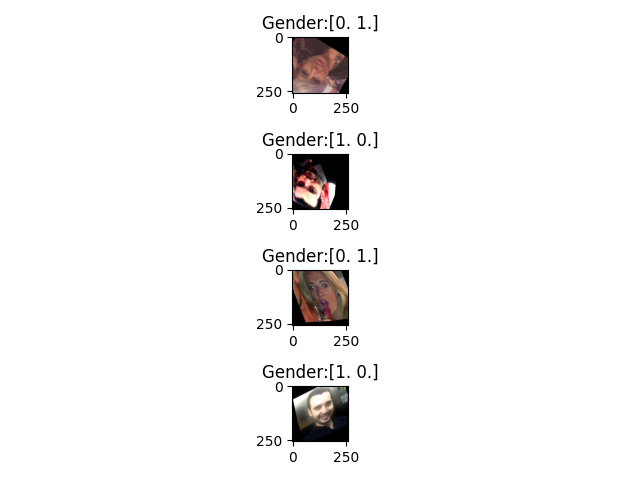

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv5'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_7')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 64

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 64)           1001856     ['tf.math.subtract[0][0]']    

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_7"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-02 02:58:55.840403: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-02 02:58:55.840422: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-02 02:58:55.840442: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-02 02:58:55.926209: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-02 02:58:55.927493: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-02 02:58:56.581908: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  13/3528 [..............................] - ETA: 14s - loss: 7156.1519 - gender_out_loss: 0.6963 - tf.math.multiply_1_loss: 5415.3369 - gender_out_accuracy: 0.4423    

2022-11-02 02:58:57.333905: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 15s 4ms/step - loss: 7719.2710 - gender_out_loss: 0.6914 - tf.math.multiply_1_loss: 5990.7261 - gender_out_accuracy: 0.5236
Epoch 1/300
   1/1000 [..............................] - ETA: 14:42 - loss: 9986.8496 - gender_out_loss: 0.7030 - tf.math.multiply_1_loss: 8229.2764 - gender_out_accuracy: 0.5000

2022-11-02 02:59:12.169485: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-02 02:59:12.169815: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   8/1000 [..............................] - ETA: 1:08 - loss: 9010.7129 - gender_out_loss: 0.7065 - tf.math.multiply_1_loss: 7244.5488 - gender_out_accuracy: 0.3438

2022-11-02 02:59:12.667420: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-02 02:59:12.668434: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-02 02:59:12.704181: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3170 callback api events and 3129 activity events. 
2022-11-02 02:59:12.732789: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-02 02:59:12.771260: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_7/log_0/plugins/profile/2022_11_02_02_59_12

2022-11-02 02:59:12.828480: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_7/log_0/plugins/profile/2022_11_02_02_59_12/rachanon-pc1.trace.json.gz


  30/1000 [..............................] - ETA: 30s - loss: 9099.0264 - gender_out_loss: 0.7041 - tf.math.multiply_1_loss: 7338.6738 - gender_out_accuracy: 0.3583

2022-11-02 02:59:12.892336: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_7/log_0/plugins/profile/2022_11_02_02_59_12

2022-11-02 02:59:12.897846: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to log/AE_7/log_0/plugins/profile/2022_11_02_02_59_12/rachanon-pc1.memory_profile.json.gz
2022-11-02 02:59:12.898758: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: log/AE_7/log_0/plugins/profile/2022_11_02_02_59_12
Dumped tool data for xplane.pb to log/AE_7/log_0/plugins/profile/2022_11_02_02_59_12/rachanon-pc1.xplane.pb
Dumped tool data for overview_page.pb to log/AE_7/log_0/plugins/profile/2022_11_02_02_59_12/rachanon-pc1.overview_page.pb
Dumped tool data for input_pipeline.pb to log/AE_7/log_0/plugins/profile/2022_11_02_02_59_12/rachanon-pc1.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to log/AE_7/log_0/plugins/profile/2022_11_02_02_59_12/ra

1000/1000 [==============================] - 23s 22ms/step - loss: 6865.7974 - gender_out_loss: 0.7084 - tf.math.multiply_1_loss: 5094.8604 - gender_out_accuracy: 0.5170 - val_loss: 5487.0815 - val_gender_out_loss: 0.6904 - val_tf.math.multiply_1_loss: 3761.1240 - val_gender_out_accuracy: 0.5289
Epoch 2/300
1000/1000 [==============================] - 21s 21ms/step - loss: 4887.7495 - gender_out_loss: 0.6781 - tf.math.multiply_1_loss: 3192.5818 - gender_out_accuracy: 0.5860 - val_loss: 4862.4141 - val_gender_out_loss: 0.6882 - val_tf.math.multiply_1_loss: 3141.9849 - val_gender_out_accuracy: 0.5348
Epoch 3/300
1000/1000 [==============================] - 21s 21ms/step - loss: 4358.6587 - gender_out_loss: 0.6631 - tf.math.multiply_1_loss: 2700.9771 - gender_out_accuracy: 0.5835 - val_loss: 4589.5034 - val_gender_out_loss: 0.6977 - val_tf.math.multiply_1_loss: 2845.1777 - val_gender_out_accuracy: 0.5054
Epoch 4/300
1000/1000 [==============================] - 21s 21ms/step - loss: 4171.1

1000/1000 [==============================] - 21s 21ms/step - loss: 2830.1650 - gender_out_loss: 0.6534 - tf.math.multiply_1_loss: 1196.6273 - gender_out_accuracy: 0.6152 - val_loss: 3351.8455 - val_gender_out_loss: 0.7575 - val_tf.math.multiply_1_loss: 1458.2191 - val_gender_out_accuracy: 0.5257
Epoch 28/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2942.0630 - gender_out_loss: 0.6813 - tf.math.multiply_1_loss: 1238.8879 - gender_out_accuracy: 0.5692 - val_loss: 3152.5227 - val_gender_out_loss: 0.6829 - val_tf.math.multiply_1_loss: 1445.2760 - val_gender_out_accuracy: 0.5516
Epoch 29/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2909.2925 - gender_out_loss: 0.6802 - tf.math.multiply_1_loss: 1208.7327 - gender_out_accuracy: 0.5598 - val_loss: 3105.3303 - val_gender_out_loss: 0.6771 - val_tf.math.multiply_1_loss: 1412.6117 - val_gender_out_accuracy: 0.5848
Epoch 30/300
1000/1000 [==============================] - 21s 21ms/step - loss: 288

1000/1000 [==============================] - 21s 21ms/step - loss: 2795.1389 - gender_out_loss: 0.6791 - tf.math.multiply_1_loss: 1097.2701 - gender_out_accuracy: 0.5627 - val_loss: 2977.7153 - val_gender_out_loss: 0.6854 - val_tf.math.multiply_1_loss: 1264.2844 - val_gender_out_accuracy: 0.5521
Epoch 54/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2762.2109 - gender_out_loss: 0.6814 - tf.math.multiply_1_loss: 1058.8345 - gender_out_accuracy: 0.5720 - val_loss: 3187.4575 - val_gender_out_loss: 0.7540 - val_tf.math.multiply_1_loss: 1302.5587 - val_gender_out_accuracy: 0.4772
Epoch 55/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2762.3567 - gender_out_loss: 0.6771 - tf.math.multiply_1_loss: 1069.6613 - gender_out_accuracy: 0.5755 - val_loss: 2940.0137 - val_gender_out_loss: 0.6753 - val_tf.math.multiply_1_loss: 1251.8260 - val_gender_out_accuracy: 0.5761
Epoch 56/300
1000/1000 [==============================] - 21s 21ms/step - loss: 271

1000/1000 [==============================] - 21s 21ms/step - loss: 2672.0906 - gender_out_loss: 0.6866 - tf.math.multiply_1_loss: 955.6241 - gender_out_accuracy: 0.5497 - val_loss: 2889.8894 - val_gender_out_loss: 0.6776 - val_tf.math.multiply_1_loss: 1195.9000 - val_gender_out_accuracy: 0.5679
Epoch 80/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2590.8357 - gender_out_loss: 0.6466 - tf.math.multiply_1_loss: 974.3901 - gender_out_accuracy: 0.6320 - val_loss: 2904.2830 - val_gender_out_loss: 0.6742 - val_tf.math.multiply_1_loss: 1218.7948 - val_gender_out_accuracy: 0.5710
Epoch 81/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2721.1646 - gender_out_loss: 0.6752 - tf.math.multiply_1_loss: 1033.1134 - gender_out_accuracy: 0.5710 - val_loss: 2880.8181 - val_gender_out_loss: 0.6783 - val_tf.math.multiply_1_loss: 1185.0732 - val_gender_out_accuracy: 0.5606
Epoch 82/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2719.

1000/1000 [==============================] - 21s 21ms/step - loss: 2607.2644 - gender_out_loss: 0.6505 - tf.math.multiply_1_loss: 980.9692 - gender_out_accuracy: 0.6183 - val_loss: 2849.6072 - val_gender_out_loss: 0.6733 - val_tf.math.multiply_1_loss: 1166.3003 - val_gender_out_accuracy: 0.5783
Epoch 106/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2655.8950 - gender_out_loss: 0.6701 - tf.math.multiply_1_loss: 980.6148 - gender_out_accuracy: 0.5888 - val_loss: 3016.7168 - val_gender_out_loss: 0.7348 - val_tf.math.multiply_1_loss: 1179.8036 - val_gender_out_accuracy: 0.4786
Epoch 107/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2648.1594 - gender_out_loss: 0.6768 - tf.math.multiply_1_loss: 956.2059 - gender_out_accuracy: 0.5790 - val_loss: 2851.0139 - val_gender_out_loss: 0.6724 - val_tf.math.multiply_1_loss: 1170.1084 - val_gender_out_accuracy: 0.5829
Epoch 108/300
1000/1000 [==============================] - 21s 21ms/step - loss: 264

1000/1000 [==============================] - 21s 21ms/step - loss: 2630.6477 - gender_out_loss: 0.6621 - tf.math.multiply_1_loss: 975.4880 - gender_out_accuracy: 0.6065 - val_loss: 2836.3943 - val_gender_out_loss: 0.6724 - val_tf.math.multiply_1_loss: 1155.3958 - val_gender_out_accuracy: 0.5778
Epoch 132/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2617.4414 - gender_out_loss: 0.6831 - tf.math.multiply_1_loss: 909.6677 - gender_out_accuracy: 0.5620 - val_loss: 2810.6497 - val_gender_out_loss: 0.6685 - val_tf.math.multiply_1_loss: 1139.3716 - val_gender_out_accuracy: 0.5947
Epoch 133/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2516.4946 - gender_out_loss: 0.6374 - tf.math.multiply_1_loss: 923.1090 - gender_out_accuracy: 0.6470 - val_loss: 2880.1296 - val_gender_out_loss: 0.6853 - val_tf.math.multiply_1_loss: 1166.9990 - val_gender_out_accuracy: 0.5641
Epoch 134/300
1000/1000 [==============================] - 21s 21ms/step - loss: 264

1000/1000 [==============================] - 21s 21ms/step - loss: 2587.1448 - gender_out_loss: 0.6529 - tf.math.multiply_1_loss: 954.7705 - gender_out_accuracy: 0.6295 - val_loss: 2858.2664 - val_gender_out_loss: 0.6773 - val_tf.math.multiply_1_loss: 1165.0426 - val_gender_out_accuracy: 0.5809
Epoch 158/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2538.9561 - gender_out_loss: 0.6458 - tf.math.multiply_1_loss: 924.3480 - gender_out_accuracy: 0.6212 - val_loss: 2784.1213 - val_gender_out_loss: 0.6668 - val_tf.math.multiply_1_loss: 1117.1199 - val_gender_out_accuracy: 0.6018
Epoch 159/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2580.6152 - gender_out_loss: 0.6543 - tf.math.multiply_1_loss: 944.9311 - gender_out_accuracy: 0.6065 - val_loss: 2811.2173 - val_gender_out_loss: 0.6671 - val_tf.math.multiply_1_loss: 1143.4769 - val_gender_out_accuracy: 0.5928
Epoch 160/300
1000/1000 [==============================] - 21s 21ms/step - loss: 257

1000/1000 [==============================] - 21s 21ms/step - loss: 2524.3364 - gender_out_loss: 0.6396 - tf.math.multiply_1_loss: 925.3407 - gender_out_accuracy: 0.6215 - val_loss: 2759.6760 - val_gender_out_loss: 0.6587 - val_tf.math.multiply_1_loss: 1112.8413 - val_gender_out_accuracy: 0.6151
Epoch 184/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2531.5505 - gender_out_loss: 0.6463 - tf.math.multiply_1_loss: 915.8788 - gender_out_accuracy: 0.6223 - val_loss: 2862.3354 - val_gender_out_loss: 0.7117 - val_tf.math.multiply_1_loss: 1082.9675 - val_gender_out_accuracy: 0.5479
Epoch 185/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2546.9543 - gender_out_loss: 0.6702 - tf.math.multiply_1_loss: 871.4762 - gender_out_accuracy: 0.5950 - val_loss: 2819.1938 - val_gender_out_loss: 0.6909 - val_tf.math.multiply_1_loss: 1092.0316 - val_gender_out_accuracy: 0.5573
Epoch 186/300
1000/1000 [==============================] - 21s 21ms/step - loss: 245

1000/1000 [==============================] - 21s 21ms/step - loss: 2537.6265 - gender_out_loss: 0.6513 - tf.math.multiply_1_loss: 909.2626 - gender_out_accuracy: 0.6210 - val_loss: 2705.4771 - val_gender_out_loss: 0.6514 - val_tf.math.multiply_1_loss: 1076.9034 - val_gender_out_accuracy: 0.6172
Epoch 210/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2508.3042 - gender_out_loss: 0.6453 - tf.math.multiply_1_loss: 895.1611 - gender_out_accuracy: 0.6438 - val_loss: 2792.4805 - val_gender_out_loss: 0.6787 - val_tf.math.multiply_1_loss: 1095.6345 - val_gender_out_accuracy: 0.5878
Epoch 211/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2483.4717 - gender_out_loss: 0.6364 - tf.math.multiply_1_loss: 892.3853 - gender_out_accuracy: 0.6342 - val_loss: 2841.2324 - val_gender_out_loss: 0.7032 - val_tf.math.multiply_1_loss: 1083.3425 - val_gender_out_accuracy: 0.5369
Epoch 212/300
1000/1000 [==============================] - 21s 21ms/step - loss: 253

1000/1000 [==============================] - 21s 21ms/step - loss: 2490.1401 - gender_out_loss: 0.6492 - tf.math.multiply_1_loss: 867.2062 - gender_out_accuracy: 0.6298 - val_loss: 2689.7439 - val_gender_out_loss: 0.6470 - val_tf.math.multiply_1_loss: 1072.3123 - val_gender_out_accuracy: 0.6184
Epoch 236/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2478.8125 - gender_out_loss: 0.6268 - tf.math.multiply_1_loss: 911.7177 - gender_out_accuracy: 0.6375 - val_loss: 2705.5364 - val_gender_out_loss: 0.6533 - val_tf.math.multiply_1_loss: 1072.3899 - val_gender_out_accuracy: 0.6172
Epoch 237/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2479.0225 - gender_out_loss: 0.6397 - tf.math.multiply_1_loss: 879.7345 - gender_out_accuracy: 0.6370 - val_loss: 2699.5862 - val_gender_out_loss: 0.6517 - val_tf.math.multiply_1_loss: 1070.2391 - val_gender_out_accuracy: 0.6123
Epoch 238/300
1000/1000 [==============================] - 21s 21ms/step - loss: 248

1000/1000 [==============================] - 21s 21ms/step - loss: 2503.3418 - gender_out_loss: 0.6446 - tf.math.multiply_1_loss: 891.7601 - gender_out_accuracy: 0.6288 - val_loss: 2638.6377 - val_gender_out_loss: 0.6377 - val_tf.math.multiply_1_loss: 1044.3888 - val_gender_out_accuracy: 0.6345
Epoch 262/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2478.2231 - gender_out_loss: 0.6449 - tf.math.multiply_1_loss: 865.9391 - gender_out_accuracy: 0.6273 - val_loss: 2639.1829 - val_gender_out_loss: 0.6397 - val_tf.math.multiply_1_loss: 1040.0305 - val_gender_out_accuracy: 0.6285
Epoch 263/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2418.1897 - gender_out_loss: 0.6225 - tf.math.multiply_1_loss: 862.0435 - gender_out_accuracy: 0.6640 - val_loss: 2636.4290 - val_gender_out_loss: 0.6371 - val_tf.math.multiply_1_loss: 1043.6704 - val_gender_out_accuracy: 0.6367
Epoch 264/300
1000/1000 [==============================] - 21s 21ms/step - loss: 240

1000/1000 [==============================] - 21s 21ms/step - loss: 2419.8467 - gender_out_loss: 0.6311 - tf.math.multiply_1_loss: 842.1158 - gender_out_accuracy: 0.6457 - val_loss: 2780.7866 - val_gender_out_loss: 0.6980 - val_tf.math.multiply_1_loss: 1035.8727 - val_gender_out_accuracy: 0.5640
Epoch 288/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2374.6506 - gender_out_loss: 0.6206 - tf.math.multiply_1_loss: 823.2711 - gender_out_accuracy: 0.6630 - val_loss: 3255.5342 - val_gender_out_loss: 0.8811 - val_tf.math.multiply_1_loss: 1052.8800 - val_gender_out_accuracy: 0.5459
Epoch 289/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2428.6030 - gender_out_loss: 0.6285 - tf.math.multiply_1_loss: 857.2692 - gender_out_accuracy: 0.6420 - val_loss: 2642.5742 - val_gender_out_loss: 0.6412 - val_tf.math.multiply_1_loss: 1039.6309 - val_gender_out_accuracy: 0.6270
Epoch 290/300
1000/1000 [==============================] - 21s 21ms/step - loss: 241

In [40]:
out = model(x)

In [41]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[6.17699738e+01, 6.02245865e+01, 5.91821365e+01],
          [5.22841911e+01, 4.44236984e+01, 3.82135391e+01],
          [4.73056374e+01, 3.84762955e+01, 3.09662857e+01],
          ...,
          [2.73388481e+00, 3.24440265e+00, 1.61698806e+00],
          [2.90060472e+00, 2.04390264e+00, 2.38928890e+00],
          [6.56746864e+00, 5.68522453e+00, 6.19935989e+00]],
 
         [[5.42873688e+01, 4.63565407e+01, 5.17784691e+01],
          [4.12907410e+01, 3.45003242e+01, 4.09654961e+01],
          [4.57254028e+01, 3.19180450e+01, 3.99182549e+01],
          ...,
          [7.67992020e-01, 5.15153527e-01, 5.47026277e-01],
          [2.24534512e+00, 1.06673193e+00, 1.46502662e+00],
          [3.75872803e+00, 1.80787456e+00, 3.38839221e+00]],
 
         [[5.46977310e+01, 4.64431992e+01, 3.76264839e+01],
          [4.00212479e+01, 2.65699139e+01, 2.74246330e+01],
          [4.06217422e+01, 3.78205261e+01, 3.23002129e+0

<IPython.core.display.Javascript object>


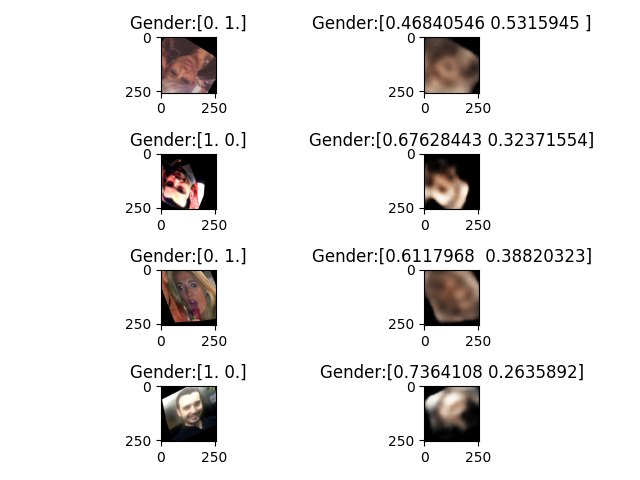

In [42]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [43]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [44]:
outTest = model(xTest)

In [45]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[1.88083286e+01, 1.75591393e+01, 1.87068977e+01],
          [1.15441990e+01, 8.44472790e+00, 5.63322830e+00],
          [6.77811432e+00, 4.36837482e+00, 2.87933350e+00],
          ...,
          [7.32144713e-02, 1.42971128e-01, 4.45336103e-02],
          [7.29408860e-02, 5.11680543e-02, 5.93072176e-02],
          [2.73501724e-01, 2.65658945e-01, 4.31094468e-01]],
 
         [[1.03661175e+01, 8.19812870e+00, 1.07473965e+01],
          [4.65630817e+00, 3.01295710e+00, 4.95536709e+00],
          [5.37435579e+00, 2.19326520e+00, 4.69590950e+00],
          ...,
          [8.54954123e-03, 4.60535288e-03, 5.70729375e-03],
          [5.25511801e-02, 1.40060484e-02, 3.09075415e-02],
          [1.02480501e-01, 2.99575925e-02, 1.31571740e-01]],
 
         [[1.20012836e+01, 7.94069242e+00, 4.99347162e+00],
          [3.69267225e+00, 1.86364794e+00, 2.26419973e+00],
          [3.41189766e+00, 3.28596497e+00, 2.24453950e+0

<IPython.core.display.Javascript object>


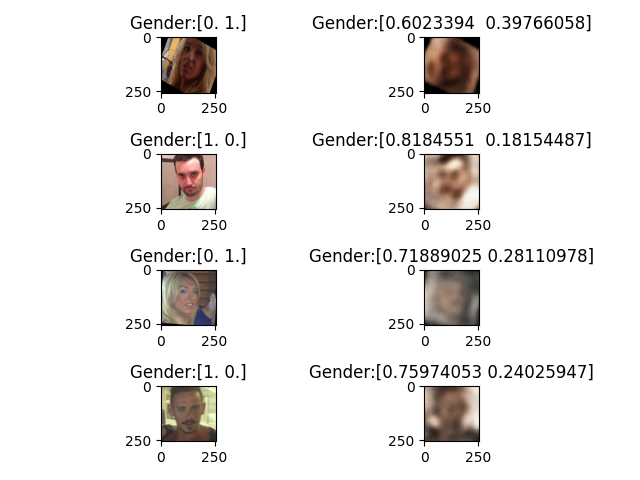

In [46]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()